PROJEKT SSN - KLASYFIKACJA DŁUGOŚCI POBYTU W SZPITALU
PRZYGOTOWANIE DANYCH
Wymiary danych: (318438, 18)
Po usunięciu braków: (313793, 18)

Łączenie kategorii Stay > 40...
Oryginalne kategorie:
Stay
21-30                 86316
11-20                 77095
31-40                 54312
51-60                 34463
0-10                  23250
41-50                 11541
71-80                 10096
More than 100 Days     6548
81-90                  4761
91-100                 2713
61-70                  2698
Name: count, dtype: int64

Po połączeniu kategorii:
Stay
21-30        86316
11-20        77095
Stay > 40    72820
31-40        54312
0-10         23250
Name: count, dtype: int64

PREPROCESSING CECH
Cechy kategoryczne: ['Hospital_type_code', 'Hospital_region_code', 'Department', 'Ward_Type', 'Ward_Facility_Code', 'Type of Admission', 'Severity of Illness', 'Age']
Wymiary po one-hot encoding: (313793, 44)

Wymiary danych:
Train: (251034, 44), Test: (62759, 44)
Liczba klas: 5
Klasy: ['0-10' '

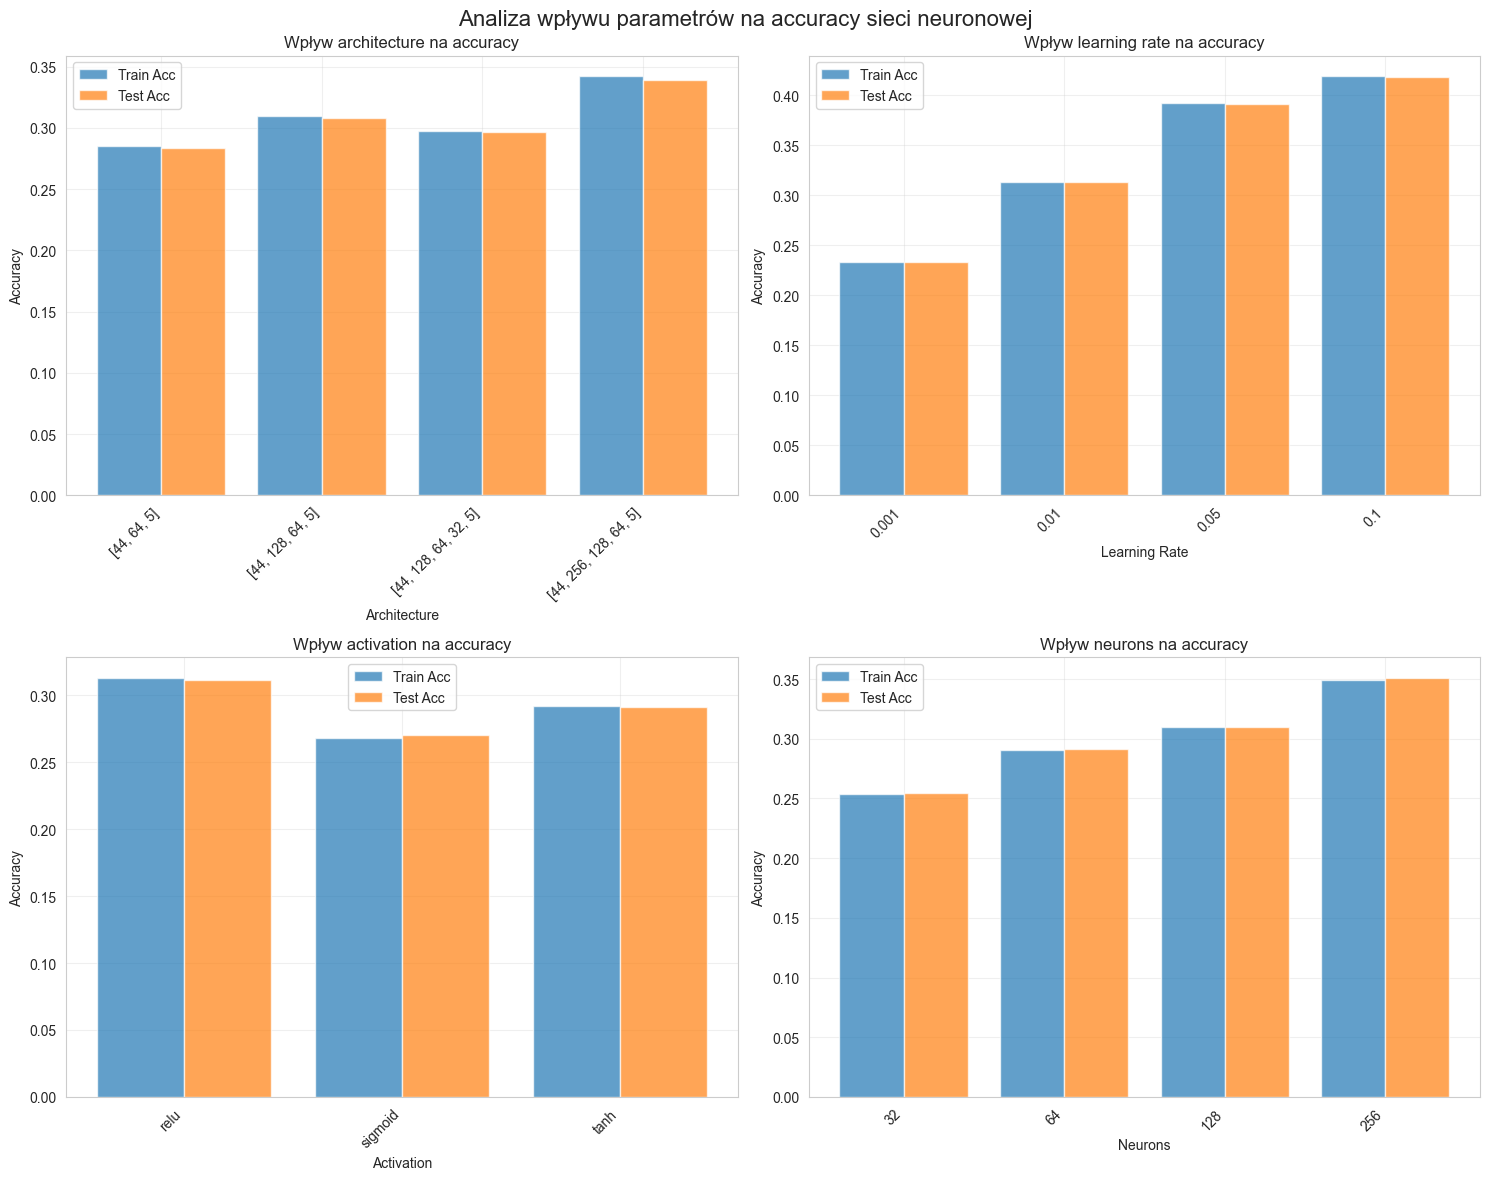


TRENOWANIE NAJLEPSZEGO MODELU
Najlepsza konfiguracja: {'architecture': [44, 128, 64, 5], 'learning_rate': 0.01, 'activation': 'relu'}

Trenowanie modelu...
Epoch 0: Loss: 1.9680, Acc: 0.1911, Val Acc: 0.1914
Epoch 20: Loss: 1.7502, Acc: 0.2265, Val Acc: 0.2276
Epoch 40: Loss: 1.6911, Acc: 0.2449, Val Acc: 0.2450
Epoch 60: Loss: 1.6510, Acc: 0.2595, Val Acc: 0.2612
Epoch 80: Loss: 1.6203, Acc: 0.2734, Val Acc: 0.2743
Epoch 100: Loss: 1.5957, Acc: 0.2859, Val Acc: 0.2870
Epoch 120: Loss: 1.5754, Acc: 0.2973, Val Acc: 0.2987
Epoch 140: Loss: 1.5582, Acc: 0.3081, Val Acc: 0.3090
Epoch 160: Loss: 1.5433, Acc: 0.3175, Val Acc: 0.3187
Epoch 180: Loss: 1.5302, Acc: 0.3264, Val Acc: 0.3292

Wyniki końcowe:
Train Accuracy: 0.3340
Test Accuracy: 0.3371


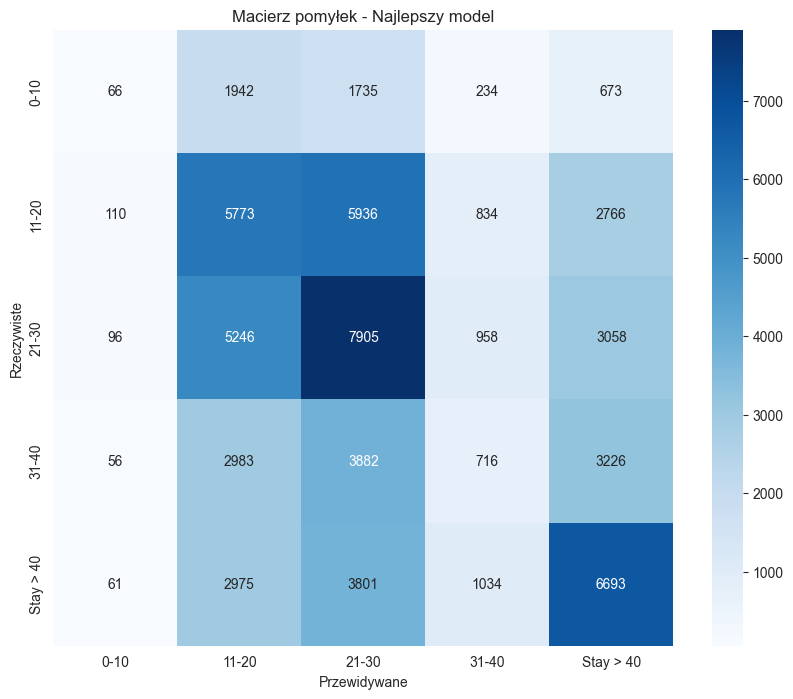


Raport klasyfikacji:
              precision    recall  f1-score   support

        0-10       0.17      0.01      0.03      4650
       11-20       0.31      0.37      0.34     15419
       21-30       0.34      0.46      0.39     17263
       31-40       0.19      0.07      0.10     10863
   Stay > 40       0.41      0.46      0.43     14564

    accuracy                           0.34     62759
   macro avg       0.28      0.27      0.26     62759
weighted avg       0.31      0.34      0.31     62759



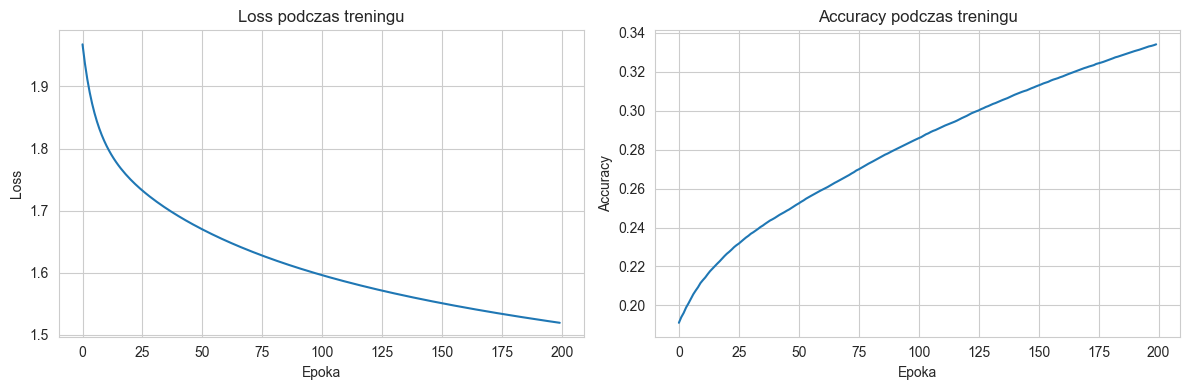


PODSUMOWANIE PROJEKTU
Problem: Klasyfikacja długości pobytu w szpitalu
Liczba cech: 44
Liczba klas: 5
Finalna accuracy: 0.3371

Przetestowane parametry:
- 4 różne architektury sieci
- 4 różne współczynniki uczenia
- 3 różne funkcje aktywacji
- 4 różne liczby neuronów

Każdy test powtórzony 3 razy dla wiarygodności wyników.


In [1]:
# -*- coding: utf-8 -*-
"""
Projekt - Sztuczne Sieci Neuronowe
Problem klasyfikacyjny: Przewidywanie długości pobytu w szpitalu
Implementacja własnej sieci neuronowej bez gotowych bibliotek uczenia
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

class NeuralNetwork:
    """Własna implementacja sieci neuronowej"""

    def __init__(self, layers, learning_rate=0.01, activation='relu'):
        """
        Inicjalizacja sieci neuronowej

        Args:
            layers: lista z liczbą neuronów w każdej warstwie [input, hidden1, hidden2, ..., output]
            learning_rate: współczynnik uczenia
            activation: funkcja aktywacji ('relu', 'sigmoid', 'tanh')
        """
        self.layers = layers
        self.learning_rate = learning_rate
        self.activation = activation
        self.weights = []
        self.biases = []
        self.history = {'loss': [], 'accuracy': []}

        # Inicjalizacja wag i biasów
        for i in range(len(layers) - 1):
            # Xavier/Glorot initialization
            w = np.random.randn(layers[i], layers[i + 1]) * np.sqrt(2.0 / layers[i])
            b = np.zeros((1, layers[i + 1]))
            self.weights.append(w)
            self.biases.append(b)

    def _activation_function(self, x, derivative=False):
        """Funkcje aktywacji"""
        if self.activation == 'relu':
            if derivative:
                return np.where(x > 0, 1, 0)
            return np.maximum(0, x)
        elif self.activation == 'sigmoid':
            sig = 1 / (1 + np.exp(-np.clip(x, -500, 500)))
            if derivative:
                return sig * (1 - sig)
            return sig
        elif self.activation == 'tanh':
            if derivative:
                return 1 - np.tanh(x)**2
            return np.tanh(x)

    def _softmax(self, x):
        """Funkcja softmax dla warstwy wyjściowej"""
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def forward(self, X):
        """Propagacja w przód"""
        self.activations = [X]
        self.z_values = []

        current_input = X

        # Warstwy ukryte
        for i in range(len(self.weights) - 1):
            z = np.dot(current_input, self.weights[i]) + self.biases[i]
            a = self._activation_function(z)
            self.z_values.append(z)
            self.activations.append(a)
            current_input = a

        # Warstwa wyjściowa
        z_output = np.dot(current_input, self.weights[-1]) + self.biases[-1]
        a_output = self._softmax(z_output)
        self.z_values.append(z_output)
        self.activations.append(a_output)

        return a_output

    def backward(self, X, y):
        """Propagacja wsteczna"""
        m = X.shape[0]

        # Błąd warstwy wyjściowej
        delta = self.activations[-1] - y

        # Gradienty dla wszystkich warstw
        weight_grads = []
        bias_grads = []

        # Warstwa wyjściowa
        weight_grad = np.dot(self.activations[-2].T, delta) / m
        bias_grad = np.sum(delta, axis=0, keepdims=True) / m
        weight_grads.append(weight_grad)
        bias_grads.append(bias_grad)

        # Warstwy ukryte (od końca)
        for i in range(len(self.weights) - 2, -1, -1):
            delta = np.dot(delta, self.weights[i + 1].T) * self._activation_function(self.z_values[i], derivative=True)

            weight_grad = np.dot(self.activations[i].T, delta) / m
            bias_grad = np.sum(delta, axis=0, keepdims=True) / m

            weight_grads.append(weight_grad)
            bias_grads.append(bias_grad)

        # Odwróć kolejność gradientów
        weight_grads.reverse()
        bias_grads.reverse()

        # Aktualizacja wag i biasów
        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * weight_grads[i]
            self.biases[i] -= self.learning_rate * bias_grads[i]

    def _compute_loss(self, y_pred, y_true):
        """Obliczanie cross-entropy loss"""
        m = y_true.shape[0]
        # Dodaj małą wartość aby uniknąć log(0)
        y_pred_clipped = np.clip(y_pred, 1e-15, 1 - 1e-15)
        loss = -np.sum(y_true * np.log(y_pred_clipped)) / m
        return loss

    def fit(self, X, y, epochs=100, X_val=None, y_val=None, verbose=True):
        """Trenowanie sieci"""
        for epoch in range(epochs):
            # Forward pass
            y_pred = self.forward(X)

            # Backward pass
            self.backward(X, y)

            # Oblicz loss i accuracy
            loss = self._compute_loss(y_pred, y)
            accuracy = self.score(X, np.argmax(y, axis=1))

            self.history['loss'].append(loss)
            self.history['accuracy'].append(accuracy)

            if verbose and epoch % 20 == 0:
                val_acc = ""
                if X_val is not None and y_val is not None:
                    val_accuracy = self.score(X_val, y_val)
                    val_acc = f", Val Acc: {val_accuracy:.4f}"

                print(f"Epoch {epoch}: Loss: {loss:.4f}, Acc: {accuracy:.4f}{val_acc}")

    def predict(self, X):
        """Predykcja"""
        output = self.forward(X)
        return np.argmax(output, axis=1)

    def score(self, X, y):
        """Obliczanie accuracy"""
        predictions = self.predict(X)
        return accuracy_score(y, predictions)

def prepare_data():
    """Przygotowanie danych"""
    print("="*60)
    print("PRZYGOTOWANIE DANYCH")
    print("="*60)

    # Wczytanie danych
    df = pd.read_csv("train_data.csv", sep=";")
    print(f"Wymiary danych: {df.shape}")

    # Usunięcie braków
    df = df.dropna()
    print(f"Po usunięciu braków: {df.shape}")

    # Połączenie kategorii Stay (zgodnie z Twoim kodem)
    print("\nŁączenie kategorii Stay > 40...")
    stay_counts = df["Stay"].value_counts()
    print("Oryginalne kategorie:")
    print(stay_counts)

    # Znajdź kategorie do połączenia
    categories_to_merge = []
    for cat in df["Stay"].unique():
        if isinstance(cat, str) and '-' in cat:
            try:
                start_val = int(cat.split('-')[0])
                if start_val > 40:
                    categories_to_merge.append(cat)
            except:
                pass
        elif 'More than' in str(cat):
            categories_to_merge.append(cat)

    # Połącz kategorie
    for cat in categories_to_merge:
        df["Stay"] = df["Stay"].replace(cat, "Stay > 40")

    print(f"\nPo połączeniu kategorii:")
    print(df["Stay"].value_counts())

    # Usuń klasy z małą liczbą próbek (< 50)
    class_counts = df["Stay"].value_counts()
    small_classes = class_counts[class_counts < 50].index.tolist()
    if small_classes:
        print(f"Usuwanie małych klas: {small_classes}")
        df = df[~df["Stay"].isin(small_classes)]

    return df

def preprocess_features(df):
    """Preprocessing cech"""
    print("\n" + "="*60)
    print("PREPROCESSING CECH")
    print("="*60)

    X = df.drop("Stay", axis=1)
    y = df["Stay"]

    # Kodowanie cech kategorycznych
    categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
    print(f"Cechy kategoryczne: {categorical_cols}")

    X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)
    print(f"Wymiary po one-hot encoding: {X_encoded.shape}")

    # Kodowanie etykiet
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)

    # One-hot encoding dla etykiet (dla sieci neuronowej)
    num_classes = len(np.unique(y_encoded))
    y_onehot = np.eye(num_classes)[y_encoded]

    # Skalowanie
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_encoded)

    class_names = le.classes_

    return X_scaled, y_onehot, y_encoded, class_names, le, scaler

def test_parameters(X_train, y_train_onehot, y_train, X_test, y_test_onehot, y_test, input_size, output_size):
    """Testowanie różnych parametrów sieci"""
    print("\n" + "="*60)
    print("TESTOWANIE PARAMETRÓW SIECI")
    print("="*60)

    results = []

    # 1. Testowanie liczby warstw ukrytych
    print("\n1. TESTOWANIE LICZBY WARSTW UKRYTYCH")
    architectures = [
        [input_size, 64, output_size],           # 1 warstwa ukryta
        [input_size, 128, 64, output_size],     # 2 warstwy ukryte
        [input_size, 128, 64, 32, output_size], # 3 warstwy ukryte
        [input_size, 256, 128, 64, output_size] # 3 warstwy (większe)
    ]

    for i, arch in enumerate(architectures):
        print(f"\nArchitektura {i+1}: {arch}")
        accuracies = []

        # Powtórz 3 razy (bo uczenie nie jest deterministyczne)
        for run in range(3):
            nn = NeuralNetwork(arch, learning_rate=0.01, activation='relu')
            nn.fit(X_train, y_train_onehot, epochs=100, verbose=False)

            train_acc = nn.score(X_train, y_train)
            test_acc = nn.score(X_test, y_test)
            accuracies.append((train_acc, test_acc))

        avg_train = np.mean([acc[0] for acc in accuracies])
        avg_test = np.mean([acc[1] for acc in accuracies])
        max_test = np.max([acc[1] for acc in accuracies])

        print(f"Średnia accuracy - Train: {avg_train:.4f}, Test: {avg_test:.4f}")
        print(f"Najlepsza test accuracy: {max_test:.4f}")

        results.append({
            'parameter': 'architecture',
            'value': str(arch),
            'avg_train_acc': avg_train,
            'avg_test_acc': avg_test,
            'max_test_acc': max_test
        })

    # 2. Testowanie współczynnika uczenia
    print("\n2. TESTOWANIE WSPÓŁCZYNNIKA UCZENIA")
    learning_rates = [0.001, 0.01, 0.05, 0.1]

    for lr in learning_rates:
        print(f"\nLearning rate: {lr}")
        accuracies = []

        for run in range(3):
            nn = NeuralNetwork([input_size, 128, 64, output_size], learning_rate=lr, activation='relu')
            nn.fit(X_train, y_train_onehot, epochs=100, verbose=False)

            train_acc = nn.score(X_train, y_train)
            test_acc = nn.score(X_test, y_test)
            accuracies.append((train_acc, test_acc))

        avg_train = np.mean([acc[0] for acc in accuracies])
        avg_test = np.mean([acc[1] for acc in accuracies])
        max_test = np.max([acc[1] for acc in accuracies])

        print(f"Średnia accuracy - Train: {avg_train:.4f}, Test: {avg_test:.4f}")
        print(f"Najlepsza test accuracy: {max_test:.4f}")

        results.append({
            'parameter': 'learning_rate',
            'value': lr,
            'avg_train_acc': avg_train,
            'avg_test_acc': avg_test,
            'max_test_acc': max_test
        })

    # 3. Testowanie funkcji aktywacji
    print("\n3. TESTOWANIE FUNKCJI AKTYWACJI")
    activations = ['relu', 'sigmoid', 'tanh']

    for activation in activations:
        print(f"\nFunkcja aktywacji: {activation}")
        accuracies = []

        for run in range(3):
            nn = NeuralNetwork([input_size, 128, 64, output_size], learning_rate=0.01, activation=activation)
            nn.fit(X_train, y_train_onehot, epochs=100, verbose=False)

            train_acc = nn.score(X_train, y_train)
            test_acc = nn.score(X_test, y_test)
            accuracies.append((train_acc, test_acc))

        avg_train = np.mean([acc[0] for acc in accuracies])
        avg_test = np.mean([acc[1] for acc in accuracies])
        max_test = np.max([acc[1] for acc in accuracies])

        print(f"Średnia accuracy - Train: {avg_train:.4f}, Test: {avg_test:.4f}")
        print(f"Najlepsza test accuracy: {max_test:.4f}")

        results.append({
            'parameter': 'activation',
            'value': activation,
            'avg_train_acc': avg_train,
            'avg_test_acc': avg_test,
            'max_test_acc': max_test
        })

    # 4. Testowanie liczby neuronów w warstwie ukrytej
    print("\n4. TESTOWANIE LICZBY NEURONÓW")
    neurons = [32, 64, 128, 256]

    for n in neurons:
        print(f"\nLiczba neuronów: {n}")
        accuracies = []

        for run in range(3):
            nn = NeuralNetwork([input_size, n, output_size], learning_rate=0.01, activation='relu')
            nn.fit(X_train, y_train_onehot, epochs=100, verbose=False)

            train_acc = nn.score(X_train, y_train)
            test_acc = nn.score(X_test, y_test)
            accuracies.append((train_acc, test_acc))

        avg_train = np.mean([acc[0] for acc in accuracies])
        avg_test = np.mean([acc[1] for acc in accuracies])
        max_test = np.max([acc[1] for acc in accuracies])

        print(f"Średnia accuracy - Train: {avg_train:.4f}, Test: {avg_test:.4f}")
        print(f"Najlepsza test accuracy: {max_test:.4f}")

        results.append({
            'parameter': 'neurons',
            'value': n,
            'avg_train_acc': avg_train,
            'avg_test_acc': avg_test,
            'max_test_acc': max_test
        })

    return results

def visualize_results(results):
    """Wizualizacja wyników"""
    print("\n" + "="*60)
    print("PODSUMOWANIE WYNIKÓW")
    print("="*60)

    # Konwersja do DataFrame
    df_results = pd.DataFrame(results)

    # Tabela wyników
    print("\nTABELA WYNIKÓW:")
    print("-" * 80)
    print(f"{'Parametr':<15} {'Wartość':<20} {'Śr.Train':<10} {'Śr.Test':<10} {'Max Test':<10}")
    print("-" * 80)

    for _, row in df_results.iterrows():
        print(f"{row['parameter']:<15} {str(row['value']):<20} {row['avg_train_acc']:.4f}    {row['avg_test_acc']:.4f}    {row['max_test_acc']:.4f}")

    # Najlepsze wyniki dla każdego parametru
    print("\nNAJLEPSZE WYNIKI DLA KAŻDEGO PARAMETRU:")
    print("-" * 60)

    for param in df_results['parameter'].unique():
        param_data = df_results[df_results['parameter'] == param]
        best_row = param_data.loc[param_data['max_test_acc'].idxmax()]
        print(f"{param}: {best_row['value']} (Test Acc: {best_row['max_test_acc']:.4f})")

    # Wykres
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Analiza wpływu parametrów na accuracy sieci neuronowej', fontsize=16)

    params = ['architecture', 'learning_rate', 'activation', 'neurons']

    for i, param in enumerate(params):
        ax = axes[i//2, i%2]
        param_data = df_results[df_results['parameter'] == param]

        x_pos = range(len(param_data))

        ax.bar([x - 0.2 for x in x_pos], param_data['avg_train_acc'],
               width=0.4, label='Train Acc', alpha=0.7)
        ax.bar([x + 0.2 for x in x_pos], param_data['avg_test_acc'],
               width=0.4, label='Test Acc', alpha=0.7)

        ax.set_xlabel(param.replace('_', ' ').title())
        ax.set_ylabel('Accuracy')
        ax.set_title(f'Wpływ {param.replace("_", " ")} na accuracy')
        ax.set_xticks(x_pos)
        ax.set_xticklabels([str(x) for x in param_data['value']], rotation=45, ha='right')
        ax.legend()
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def train_best_model(X_train, y_train_onehot, y_train, X_test, y_test_onehot, y_test,
                    input_size, output_size, class_names):
    """Trenowanie najlepszego modelu"""
    print("\n" + "="*60)
    print("TRENOWANIE NAJLEPSZEGO MODELU")
    print("="*60)

    # Na podstawie testów - możesz dostosować te parametry
    best_config = {
        'architecture': [input_size, 128, 64, output_size],
        'learning_rate': 0.01,
        'activation': 'relu'
    }

    print(f"Najlepsza konfiguracja: {best_config}")

    # Trenowanie z większą liczbą epok
    nn = NeuralNetwork(best_config['architecture'],
                      learning_rate=best_config['learning_rate'],
                      activation=best_config['activation'])

    print("\nTrenowanie modelu...")
    nn.fit(X_train, y_train_onehot, epochs=200,
           X_val=X_test, y_val=y_test, verbose=True)

    # Ewaluacja
    train_acc = nn.score(X_train, y_train)
    test_acc = nn.score(X_test, y_test)

    print(f"\nWyniki końcowe:")
    print(f"Train Accuracy: {train_acc:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")

    # Predykcje
    y_pred = nn.predict(X_test)

    # Macierz pomyłek
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Macierz pomyłek - Najlepszy model')
    plt.xlabel('Przewidywane')
    plt.ylabel('Rzeczywiste')
    plt.show()

    # Raport klasyfikacji
    print("\nRaport klasyfikacji:")
    print(classification_report(y_test, y_pred, target_names=class_names))

    # Wykres historii uczenia
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(nn.history['loss'])
    plt.title('Loss podczas treningu')
    plt.xlabel('Epoka')
    plt.ylabel('Loss')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(nn.history['accuracy'])
    plt.title('Accuracy podczas treningu')
    plt.xlabel('Epoka')
    plt.ylabel('Accuracy')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return nn, test_acc

def main():
    """Główna funkcja"""
    print("="*80)
    print("PROJEKT SSN - KLASYFIKACJA DŁUGOŚCI POBYTU W SZPITALU")
    print("="*80)

    # 1. Przygotowanie danych
    df = prepare_data()

    # 2. Preprocessing
    X, y_onehot, y_encoded, class_names, le, scaler = preprocess_features(df)

    # 3. Podział na zbiory
    X_train, X_test, y_train_onehot, y_test_onehot, y_train, y_test = train_test_split(
        X, y_onehot, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
    )

    input_size = X_train.shape[1]
    output_size = len(class_names)

    print(f"\nWymiary danych:")
    print(f"Train: {X_train.shape}, Test: {X_test.shape}")
    print(f"Liczba klas: {output_size}")
    print(f"Klasy: {class_names}")

    # 4. Testowanie parametrów
    results = test_parameters(X_train, y_train_onehot, y_train,
                            X_test, y_test_onehot, y_test,
                            input_size, output_size)

    # 5. Wizualizacja wyników
    visualize_results(results)

    # 6. Trenowanie najlepszego modelu
    best_model, final_accuracy = train_best_model(X_train, y_train_onehot, y_train,
                                                 X_test, y_test_onehot, y_test,
                                                 input_size, output_size, class_names)

    print("\n" + "="*80)
    print("PODSUMOWANIE PROJEKTU")
    print("="*80)
    print(f"Problem: Klasyfikacja długości pobytu w szpitalu")
    print(f"Liczba cech: {input_size}")
    print(f"Liczba klas: {output_size}")
    print(f"Finalna accuracy: {final_accuracy:.4f}")
    print("\nPrzetestowane parametry:")
    print("- 4 różne architektury sieci")
    print("- 4 różne współczynniki uczenia")
    print("- 3 różne funkcje aktywacji")
    print("- 4 różne liczby neuronów")
    print("\nKażdy test powtórzony 3 razy dla wiarygodności wyników.")

if __name__ == "__main__":
    main()

11008.0


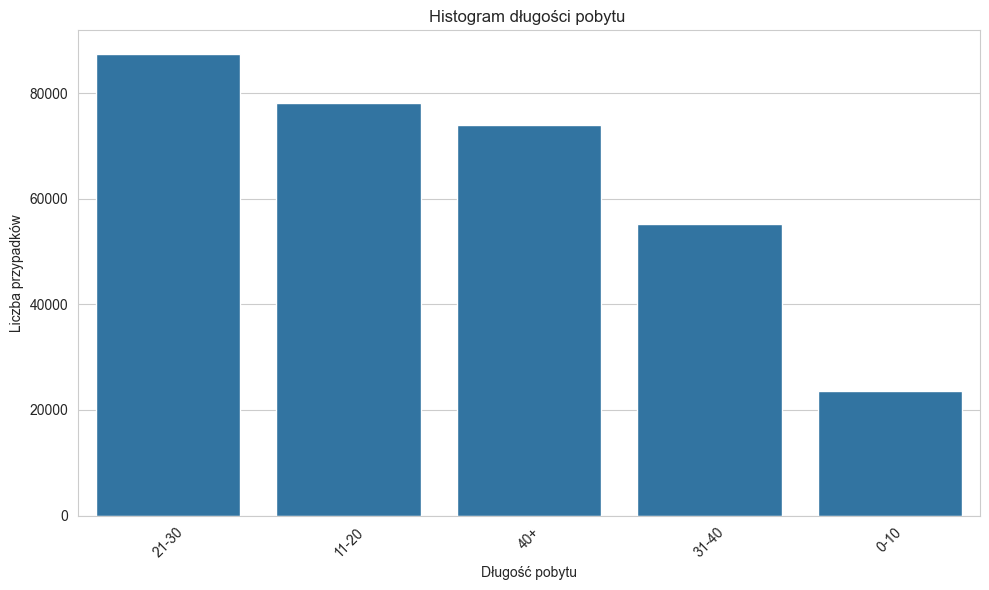

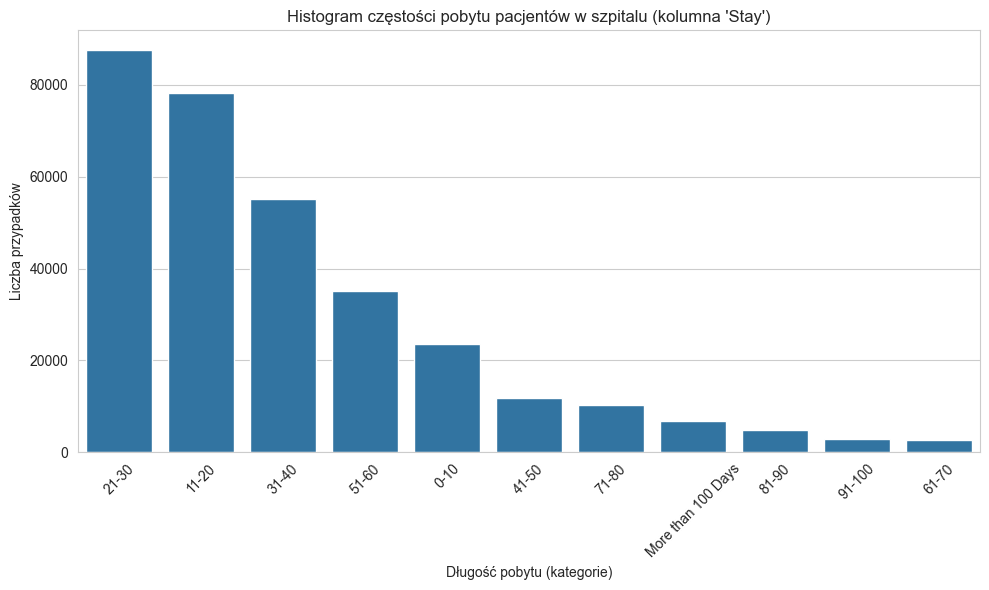

In [10]:
df=pd.read_csv("train_data.csv",sep=";")
print(max(df['Admission_Deposit']))
import pandas as pd

# Przykład danych
# df = pd.read_csv("twoj_plik.csv")  # lub masz już df

# Łączenie klas "Stay" powyżej 40 w jedną kategorię "40+"
df['Stay_cleaned'] = df['Stay'].replace({
    '41-50': '40+',
    '51-60': '40+',
    '61-70': '40+',
    '71-80': '40+',
    '81-90': '40+',
    '91-100': '40+',
    'More than 100 Days': '40+'
})
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Stay_cleaned', order=df['Stay_cleaned'].value_counts().index)

plt.title("Histogram długości pobytu ")
plt.xlabel("Długość pobytu")
plt.ylabel("Liczba przypadków")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Załaduj dane (załóżmy, że masz je w DataFrame df)
# df = pd.read_csv("twoj_plik.csv")  # jeśli dane są w pliku

# Histogram częstości unikalnych klas (np. "0-10", "11-20", itp.)
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Stay', order=df['Stay'].value_counts().index)

plt.title("Histogram częstości pobytu pacjentów w szpitalu (kolumna 'Stay')")
plt.xlabel("Długość pobytu (kategorie)")
plt.ylabel("Liczba przypadków")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
